<a href="https://colab.research.google.com/github/apoorvajainrp21/IntrusionDetectionSystem/blob/main/IDS_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the dataset
url = "https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain+.txt"
columns = [f"feature_{i}" for i in range(41)] + ['label']
data = pd.read_csv(url, header=None, names=columns)

# Preprocess the data
categorical_columns = data.select_dtypes(include=['object']).columns
for col in categorical_columns:
    label_encoder = LabelEncoder()
    data[col] = label_encoder.fit_transform(data[col])

# Separate features and target
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

In [3]:
# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # Probability estimates for ROC curve

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.90


Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.71      0.77        17
           1       0.67      0.63      0.65        19
           2       0.62      0.59      0.61        17
           3       0.68      0.52      0.59        25
           4       0.61      0.50      0.55        28
           5       0.52      0.46      0.49        26
           6       0.29      0.37      0.32        27
           7       0.52      0.37      0.43        43
           8       0.55      0.32      0.41        37
           9       0.57      0.60      0.58        52
          10       0.59      0.61      0.60        79
          11       0.79      0.73      0.76       212
          12       0.72      0.71      0.71       209
          13       0.58      0.52      0.54       130
          14       0.73      0.65      0.69       225
          15       0.85      0.90      0.88      1184
          16       0.77      0.70      0.73       742
   

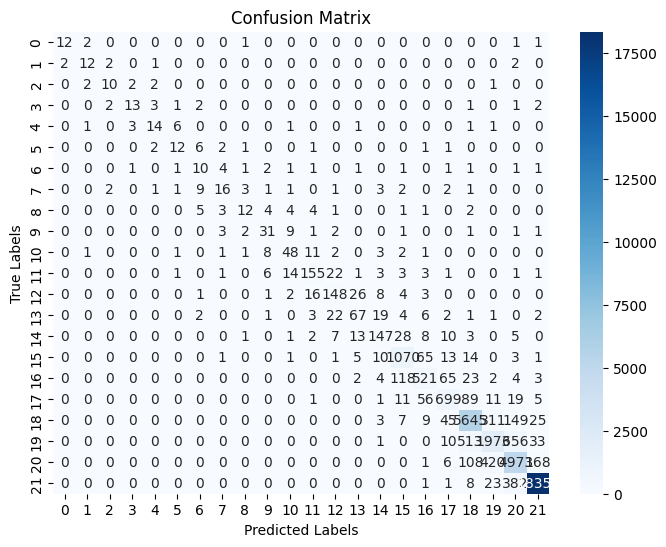

In [4]:
# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

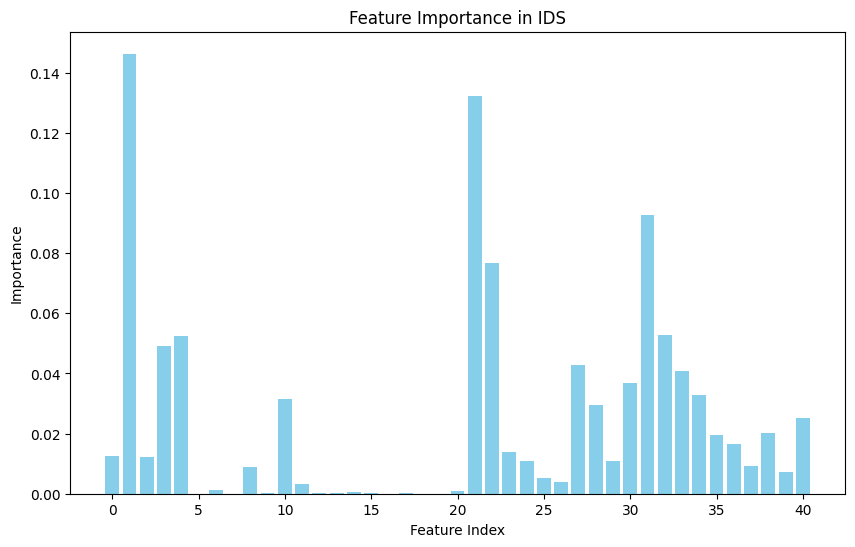

In [5]:
# Feature Importance
feature_importances = model.feature_importances_
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances, color='skyblue')
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.title("Feature Importance in IDS")
plt.show()

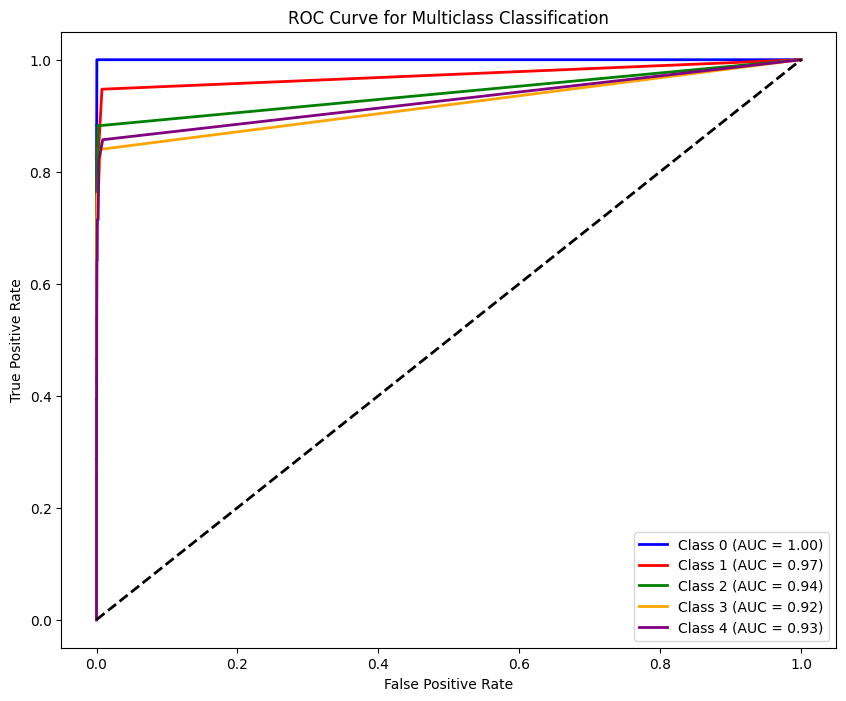

In [6]:
# ROC Curve
from sklearn.preprocessing import label_binarize

# Binarize the labels for ROC curve (one-vs-rest)
classes = np.unique(y_test)
y_test_binarized = label_binarize(y_test, classes=classes)
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], model.predict_proba(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange', 'purple']
for i, color in zip(range(n_classes), colors[:n_classes]):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f"Class {classes[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Multiclass Classification")
plt.legend(loc="lower right")
plt.show()

In [7]:
!pip install lime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=24aca33a04e8a90bea2b6ee665d5de14f464348597146510a68ba9618e015c5b
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [8]:
import lime
from lime import lime_tabular


In [9]:
from lime.lime_tabular import LimeTabularExplainer

# LIME Explainer
explainer = LimeTabularExplainer(
    X_train,
    feature_names=[f"feature_{i}" for i in range(X.shape[1])],
    class_names=np.unique(y).astype(str),
    discretize_continuous=True
)

# Choose an instance to explain
instance_index = 0  # Change index for different instances
instance = X_test[instance_index]

# Generate explanation
explanation = explainer.explain_instance(
    instance,
    model.predict_proba,
    num_features=10
)



# Save explanation to HTML file
explanation.save_to_file("lime_explanation.html")
